In [49]:
# !pip install transformers
# !pip install pillow
# !conda install -c conda-forge charset-normalizer -y
# !conda install pytorch torchvision -c pytorch -y
# !pip install datasets
# !pip install grad-cam
# !pip install imageio

In [101]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
from datasets import load_dataset
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
import imageio
from typing import List, Callable, Optional

image = Image.open('./sample.jpeg')
img_tensor = transforms.ToTensor()(image)

class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]
    
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module=img_tensor,
                          input_image: Image=image,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
        return np.hstack(results)
    
    
def print_top_categories(model, img_tensor, top_k=5):
    logits = model(img_tensor.unsqueeze(0)).logits
    indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1]
    for i in indices:
        print(f"Predicted class {i}: {model.config.id2label[i]}")

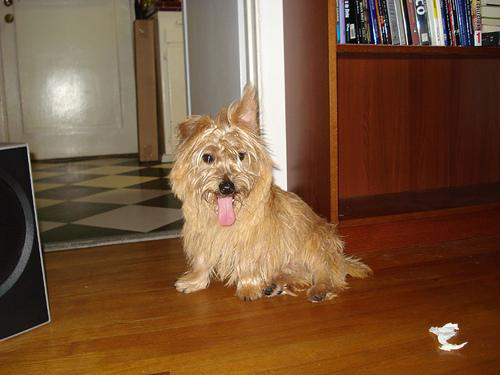

In [103]:
display(image)

In [104]:
print(model.resnet.encoder)

ResNetEncoder(
  (stages): ModuleList(
    (0): ResNetStage(
      (layers): Sequential(
        (0): ResNetBottleNeckLayer(
          (shortcut): ResNetShortCut(
            (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (layer): Sequential(
            (0): ResNetConvLayer(
              (convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (activation): ReLU()
            )
            (1): ResNetConvLayer(
              (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (activation): ReLU()
            )
        

In [105]:
from transformers import ResNetForImageClassification
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "cairn, cairn terrier"))]
list_of_images = []
for i in model.resnet.encoder.stages:
    for j in i.layers:
        target_layer = j
        list_of_images.append(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layer,
                      targets_for_gradcam=targets_for_gradcam,
                      reshape_transform=None)))
print_top_categories(model, img_tensor)

Predicted class 192: cairn, cairn terrier
Predicted class 186: Norwich terrier
Predicted class 185: Norfolk terrier
Predicted class 199: Scotch terrier, Scottish terrier, Scottie
Predicted class 201: silky terrier, Sydney silky


In [106]:
image_files = []
for i, img in enumerate(list_of_images):
    path = f'images/temp_image_{i}.png'
    img.save(path)
    image_files.append(path)

In [107]:

with imageio.get_writer('my_animation.gif', mode='I', duration=0.5) as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)

In [ ]:
# https://www.mathworks.com/help/deeplearning/ug/gradcam-explains-why.html
# https://www.mathworks.com/help/deeplearning/ug/investigate-network-predictions-using-class-activation-mapping.html
# https://www.mathworks.com/help/deeplearning/ug/visualize-features-of-a-convolutional-neural-network.html
# https://jacobgil.github.io/pytorch-gradcam-book/HuggingFace.html
# https://www.mathworks.com/matlabcentral/answers/2016701-how-to-plot-features-of-resnet-50-when-input-given-is-image?s_tid=prof_contriblnk